# Requirements

In [9]:
import os
import json
import pandas as pd
import numpy as np
import json
import pickle
import random
import unicodedata
import requests
import re

### plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

#from scipy import stats

import spacy
from spacy.tokens import DocBin



import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
from google.oauth2 import service_account # based on google-auth library
import sddk

In [2]:
conf = sddk.configure("SDAM_root", "648597@au.dk")

sciencedata.dk username (format '123456@au.dk'):  648597@au.dk
sciencedata.dk password:  ········


connection with shared folder established with you as its owner
endpoint variable has been configured to: https://sciencedata.dk/files/SDAM_root/


In [5]:
# to access gsheet, you need Google Service Account key json file
# I have mine located in my personal space on sciencedata.dk, so I read it from there:

# (1) read the file and parse its content
file_data = conf[0].get("https://sciencedata.dk/files/ServiceAccountsKey.json").json()
# (2) transform the content into crendentials object
credentials = service_account.Credentials.from_service_account_info(file_data)
# (3) specify your usage of the credentials
scoped_credentials = credentials.with_scopes(['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive'])
# (4) use the constrained credentials for authentication of gspread package
gc = gspread.Client(auth=scoped_credentials)

AGT_overview = gc.open_by_url("https://docs.google.com/spreadsheets/d/1iVta_FuEDgUM_Lf_yByrdbbXNoVH_dnVZs6QRyYv1NM/edit?usp=sharing")

CEMRAM_OVERVIEW = gc.open_by_url("https://docs.google.com/spreadsheets/d/1W5lBT2vxPXJZP06dRacNgEaM9wF9UlFnxiPq28vJJTg/edit?usp=sharing")

# AGT_metadata = gc.open_by_url("https://docs.google.com/spreadsheets/d/1hEUnL3E07F-EnE3wYnk1V91aXfPDrcnhFHKjD-04CM0/edit?usp=sharing")

In [6]:
# read the dataset
try:
    AGT = pd.read_json("../data/large_files/AGT.json")
except: 
    AGT = sddk.read_file("SDAM_data/AGT/AGT_20201027.json", "df", conf)


In [7]:
AGT.head(5)

,filename,author,title,string,wordcount,author_id,doc_id,raw_date,date_avr,date_probs,date_manual,provenience,clean_string,sentences
0,tlg0001.tlg001.perseus-grc2.xml,Apollonius Rhodius,Argonautica,"ἀρχόμενος σέο, Φοῖβε, παλαιγενέων κλέα φωτῶν μ...",38822,tlg0001,tlg0001.tlg001,3 B.C.,-2.5,{'-2.5': 1},-2.5,pagan,"ἀρχόμενος σέο, Φοῖβε, παλαιγενέων κλέα φωτῶν μ...","[ἀρχόμενος σέο, Φοῖβε, παλαιγενέων κλέα φωτῶν ..."
1,tlg0003.tlg001.perseus-grc2.xml,Thucydides,The Peloponnesian War,\nΘουκυδίδης Ἀθηναῖος ξυνέγραψε τὸν πόλεμον τῶ...,150126,tlg0003,tlg0003.tlg001,5 B.C.,-4.5,{'-4.5': 1},-4.5,pagan,Θουκυδίδης Ἀθηναῖος ξυνέγραψε τὸν πόλεμον τῶν...,[\nΘουκυδίδης Ἀθηναῖος ξυνέγραψε τὸν πόλεμον τ...
2,tlg0004.tlg001.perseus-grc1.xml,Diogenes Laertius,Lives of Eminent Philosophers,Τὸ τῆς φιλοσοφίας ἔργον ἔνιοί φασιν ἀπὸ βαρβάρ...,110773,tlg0004,tlg0004.tlg001,A.D. 3,2.5,{'2.5': 1},NaN,,Τὸ τῆς φιλοσοφίας ἔργον ἔνιοί φασιν ἀπὸ βαρβάρ...,[Τὸ τῆς φιλοσοφίας ἔργον ἔνιοί φασιν ἀπὸ βαρβά...
3,tlg0005.tlg001.perseus-grc1.xml,Theocritus,Idylls,\n̔Αδύ τι τὸ ψιθύρισμα καὶ ἁ πίτυς αἰπόλε τήνα...,19200,tlg0005,tlg0005.tlg001,4-3 B.C.,-3.0,"{'-3.5': 0.5, '-2.5': 0.5}",NaN,,"̔Αδύ τι τὸ ψιθύρισμα καὶ ἁ πίτυς αἰπόλε τήνα,...",[\n̔Αδύ τι τὸ ψιθύρισμα καὶ ἁ πίτυς αἰπόλε τήν...
4,tlg0005.tlg002.perseus-grc1.xml,Theocritus,Epigrams,τὰ ῥόδα τὰ δροσόεντα καὶ ἁ κατάπυκνος ἐκείνα ἕ...,1734,tlg0005,tlg0005.tlg002,4-3 B.C.,-3.0,"{'-3.5': 0.5, '-2.5': 0.5}",NaN,,τὰ ῥόδα τὰ δροσόεντα καὶ ἁ κατάπυκνος ἐκείνα ἕ...,[τὰ ῥόδα τὰ δροσόεντα καὶ ἁ κατάπυκνος ἐκείνα ...


In [10]:
doc_bin_bytes_series_back = pd.read_pickle("../data/large_files/doc_bin_bytes_series.pickle")
doc_bin_series = doc_bin_bytes_series_back.apply(DocBin().from_bytes)
doc_bin_series

In [11]:
doc_bin_series[0]

In [13]:
nlp = spacy.load("../spacy_model")

In [14]:
list(doc_bin_series[0].get_docs(nlp.vocab))

[<Ἀρχὴ τοῦ ᾱ τμήματος.,
 Πρᾶξις ᾱ> p.,
 16al Πρῶτον δεῖ θέσθαι τί ὄνομα καὶ τί ῥῆμα.,
 ἔπειτα
  ἐστιν ἀπόφασις καὶ κατάφασις καὶ ἀπόφανσις καὶ λόγος καὶ
 τὰ ἑξῆς.,
 Προοίμιον ἔχει ἡ παροῦσα πραγματεία διμερές.,
 καὶ ἐν μὲν τῷ ᾱ
 μέρει ποιεῖται τὴν ἀπαρίθμησιν αὐτῶν τούτων περὶ ὧν μέλλει διαλέγεσθαι
 ἐν τῷ ᾱ τμήματι, ἔτι δὲ καὶ θεώρημά τι παραδίδωσιν· ἐν δὲ τῷ ݲ
  ἀναλογίαν τινὰ τῶν φωνῶν πρὸς τὰ νοήματα διέξεισιν.,
 τὴν μὲν ἀπαρίθμησιν
 λέγων ὅτι δεῖ πρότερον ὁρίσασθαι τί ὄνομα καὶ τί ῥῆμα, εἶτα τί ἐστιν
 ἀπόφασις καὶ κατάφασις καὶ ἀπόφανσις καὶ λόγος.,
 καὶ αὕτη μέν
 ἐστιν ἡ ἀπαρίθμησις· τὸ δὲ θεώρημα τοιοῦτόν ἐστιν, ὅτι δ ὄντων, γραμμάτων
 φωνῶν, νοήματων πραγμάτων, δύο τούτων φύσει εἰσί, τὰ δὲ ἕτερα
  δύο θέσει.,
 τοῦτο δὲ δείκνυσι τοῦτον τὸν τρόπον· τὰ γράμματα καὶ τὰ ὀνόματα
 οὐ παρὰ πᾶσιν τὰ αὐτά· τὰ δὲ μὴ παρὰ πᾶσιν τὰ αὐτὰ οὐ φύσει·
 τὰ γράμματα ἄρα καὶ τὰ ὀνόματα οὐ φύσει.,
 ὅτι μὲν οὖν τὰ ὀνόματα καὶ
 τὰ γράμματα οὐκ εἰσὶν παρὰ πᾶσιν τὰ αὐτὰ αὐτόθεν ὡμολόγηται.,
 ἄλλος
 γὰρ τ

# TLG epithet

In [29]:
resp = requests.get("https://raw.githubusercontent.com/kylepjohnson/cltk/master/cltk/corpus/greek/tlg/author_epithet.json")
tlg_author_epithet = json.loads(resp.content)

In [38]:
tlg_author_epithet_reversed = {}
for key in tlg_author_epithet.keys():
    for author_id in tlg_author_epithet[key]:
        tlg_author_epithet_reversed["tlg" + author_id] = key           

In [42]:
tlg_author_epithet_reversed

def get_epithet(author_id): # we use doc_id, since author id was modified
    try:
        epithets = tlg_author_epithet_reversed[author_id[:7]]
    except:
        epithets = []
    return epithets

AGT["tlg_epithet"] = AGT["author_id"].apply(get_epithet)

In [70]:
# read the dataset
sddk.write_file("SDAM_data/AGT/AGT_20201027.json", AGT, conf)

A file with the same name ("AGT_20201027.json") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'pandas.core.frame.DataFrame'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/AGT/AGT_20201027.json"


# Export latest data for improvement...

In [43]:
AGT.columns

Index(['filename', 'author', 'title', 'string', 'wordcount', 'author_id',
       'doc_id', 'raw_date', 'date_avr', 'date_probs', 'date_manual',
       'provenience', 'lemmata', 'lemmata_wordcount', 'lemmatized_sentences',
       'n_sentences', 'tlg_epithet'],
      dtype='object')

In [44]:
AGT.head(5)

,filename,author,title,string,wordcount,author_id,doc_id,raw_date,date_avr,date_probs,date_manual,provenience,lemmata,lemmata_wordcount,lemmatized_sentences,n_sentences,tlg_epithet
0,tlg0001.tlg001.perseus-grc2.xml,Apollonius Rhodius,Argonautica,"ἀρχόμενος σέο, Φοῖβε, παλαιγενέων κλέα φωτῶν μ...",38822,tlg0001,tlg0001.tlg001,3 B.C.,-2.5,{'-2.5': 1},-2.5,pagan,"[σέο, φοῖβος, παλαιγενής, κλέος, φάος, μιμνήσκ...",24237,"[[σέο, φοῖβος, παλαιγενής, κλέος, φάος, μιμνήσ...",3230,Epici/-ae
1,tlg0003.tlg001.perseus-grc2.xml,Thucydides,The Peloponnesian War,\nΘουκυδίδης Ἀθηναῖος ξυνέγραψε τὸν πόλεμον τῶ...,150126,tlg0003,tlg0003.tlg001,5 B.C.,-4.5,{'-4.5': 1},-4.5,pagan,"[θουκυδίδης, Ἀθηναῖος, συγγράφω, πόλεμος, Πελο...",68154,"[[θουκυδίδης, Ἀθηναῖος, συγγράφω, πόλεμος, Πελ...",6057,Historici/-ae
2,tlg0004.tlg001.perseus-grc1.xml,Diogenes Laertius,Lives of Eminent Philosophers,Τὸ τῆς φιλοσοφίας ἔργον ἔνιοί φασιν ἀπὸ βαρβάρ...,110773,tlg0004,tlg0004.tlg001,A.D. 3,2.5,{'2.5': 1},NaN,,"[φιλοσοφία, ἔργον, ἔνιοί, φάσις, βάρβαρος, ἄρχ...",55323,"[[φιλοσοφία, ἔργον, ἔνιοί, φάσις, βάρβαρος, ἄρ...",9906,Biographi
3,tlg0005.tlg001.perseus-grc1.xml,Theocritus,Idylls,\n̔Αδύ τι τὸ ψιθύρισμα καὶ ἁ πίτυς αἰπόλε τήνα...,19200,tlg0005,tlg0005.tlg001,4-3 B.C.,-3.0,"{'-3.5': 0.5, '-2.5': 0.5}",NaN,,"[αδύ, ψιθύρισμα, πίτυς, αἰπόλος, ἐκεῖνος, πότη...",12177,"[[αδύ, ψιθύρισμα, πίτυς, αἰπόλος, ἐκεῖνος, πότ...",1725,Bucolici
4,tlg0005.tlg002.perseus-grc1.xml,Theocritus,Epigrams,τὰ ῥόδα τὰ δροσόεντα καὶ ἁ κατάπυκνος ἐκείνα ἕ...,1734,tlg0005,tlg0005.tlg002,4-3 B.C.,-3.0,"{'-3.5': 0.5, '-2.5': 0.5}",NaN,,"[ῥοδῆ, δροσόεντα, κατάπυκνος, ἐκεῖνος, ἕρπυλλο...",1089,"[[ῥοδῆ, δροσόεντα, κατάπυκνος, ἐκεῖνος, ἕρπυλλ...",135,Bucolici


In [45]:
set_with_dataframe(CEMRAM_OVERVIEW.worksheet("works_overview"), AGT.drop(["string", "lemmata", "lemmatized_sentences"], axis=1))

# A preliminary overview

In [46]:
len(AGT)

1457

In [47]:
### total number of words
AGT["wordcount"].sum()

33419267

In [48]:
len(AGT[AGT["date_avr"].notnull()])

1359

In [49]:
# number of documents before the end of the 4th c. CE

len(AGT[AGT["date_avr"].notnull()][AGT["date_avr"] < 4])

/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


1255

# Comparing different approaches to dating

In [50]:
AGT.head(5)

,filename,author,title,string,wordcount,author_id,doc_id,raw_date,date_avr,date_probs,date_manual,provenience,lemmata,lemmata_wordcount,lemmatized_sentences,n_sentences,tlg_epithet
0,tlg0001.tlg001.perseus-grc2.xml,Apollonius Rhodius,Argonautica,"ἀρχόμενος σέο, Φοῖβε, παλαιγενέων κλέα φωτῶν μ...",38822,tlg0001,tlg0001.tlg001,3 B.C.,-2.5,{'-2.5': 1},-2.5,pagan,"[σέο, φοῖβος, παλαιγενής, κλέος, φάος, μιμνήσκ...",24237,"[[σέο, φοῖβος, παλαιγενής, κλέος, φάος, μιμνήσ...",3230,Epici/-ae
1,tlg0003.tlg001.perseus-grc2.xml,Thucydides,The Peloponnesian War,\nΘουκυδίδης Ἀθηναῖος ξυνέγραψε τὸν πόλεμον τῶ...,150126,tlg0003,tlg0003.tlg001,5 B.C.,-4.5,{'-4.5': 1},-4.5,pagan,"[θουκυδίδης, Ἀθηναῖος, συγγράφω, πόλεμος, Πελο...",68154,"[[θουκυδίδης, Ἀθηναῖος, συγγράφω, πόλεμος, Πελ...",6057,Historici/-ae
2,tlg0004.tlg001.perseus-grc1.xml,Diogenes Laertius,Lives of Eminent Philosophers,Τὸ τῆς φιλοσοφίας ἔργον ἔνιοί φασιν ἀπὸ βαρβάρ...,110773,tlg0004,tlg0004.tlg001,A.D. 3,2.5,{'2.5': 1},NaN,,"[φιλοσοφία, ἔργον, ἔνιοί, φάσις, βάρβαρος, ἄρχ...",55323,"[[φιλοσοφία, ἔργον, ἔνιοί, φάσις, βάρβαρος, ἄρ...",9906,Biographi
3,tlg0005.tlg001.perseus-grc1.xml,Theocritus,Idylls,\n̔Αδύ τι τὸ ψιθύρισμα καὶ ἁ πίτυς αἰπόλε τήνα...,19200,tlg0005,tlg0005.tlg001,4-3 B.C.,-3.0,"{'-3.5': 0.5, '-2.5': 0.5}",NaN,,"[αδύ, ψιθύρισμα, πίτυς, αἰπόλος, ἐκεῖνος, πότη...",12177,"[[αδύ, ψιθύρισμα, πίτυς, αἰπόλος, ἐκεῖνος, πότ...",1725,Bucolici
4,tlg0005.tlg002.perseus-grc1.xml,Theocritus,Epigrams,τὰ ῥόδα τὰ δροσόεντα καὶ ἁ κατάπυκνος ἐκείνα ἕ...,1734,tlg0005,tlg0005.tlg002,4-3 B.C.,-3.0,"{'-3.5': 0.5, '-2.5': 0.5}",NaN,,"[ῥοδῆ, δροσόεντα, κατάπυκνος, ἐκεῖνος, ἕρπυλλο...",1089,"[[ῥοδῆ, δροσόεντα, κατάπυκνος, ἐκεῖνος, ἕρπυλλ...",135,Bucolici


In [51]:
centuries = [num + 0.5 for num in range(-8, 4)]
centuries

[-7.5, -6.5, -5.5, -4.5, -3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5]

In [52]:
dates = [num /10 for num in range(-75, 40, 5)]
print(dates)

[-7.5, -7.0, -6.5, -6.0, -5.5, -5.0, -4.5, -4.0, -3.5, -3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5]


In [53]:
AGT["date_probs"].tolist()[0]["-2.5"]

1

In [54]:
centuries_aor = {}
def get_prob(x):
    try: return x[str(century)]
    except: return 0
for century in centuries:
    centuries_aor[century] =  AGT["date_probs"].apply(get_prob).sum()
centuries_aor

{-7.5: 6.8331,
 -6.5: 3.8331,
 -5.5: 9.8331,
 -4.5: 139.0,
 -3.5: 234.0001,
 -2.5: 42.2501,
 -1.5: 12.9586,
 -0.5: 40.8964,
 0.5: 168.3657,
 1.5: 450.1011,
 2.5: 77.97030000000001,
 3.5: 68.9081}

In [55]:
centuries_aor_df = pd.DataFrame(centuries_aor, index=[0]).T[:6]
centuries_aor_df

,0
-7.5,6.8331
-6.5,3.8331
-5.5,9.8331
-4.5,139.0000
-3.5,234.0001
-2.5,42.2501
-1.5,12.9586
-0.5,40.8964
0.5,168.3657
1.5,450.1011


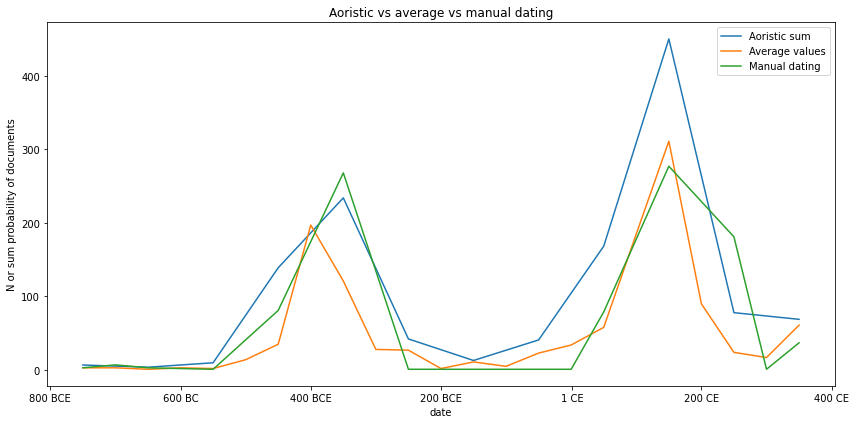

In [56]:
### documents with probabilities
fig, ax = plt.subplots(figsize=(12, 6), tight_layout=True)

centuries_aor_df.plot(ax=ax)
AGT.groupby("date_avr").size()[:3.5].plot(ax=ax)
AGT.groupby("date_manual").size()[:3.5].plot(ax=ax)
ax.set_xlabel("date")
ax.set_ylabel("N or sum probability of documents")
ax.set_xticks([-8, -6, -4, -2, 0.01, 2, 4])
ax.set_xticklabels(["800 BCE", "600 BC", "400 BCE", "200 BCE", "1 CE", "200 CE", "400 CE"])

plt.title("Aoristic vs average vs manual dating")
plt.legend(labels=["Aoristic sum", "Average values", "Manual dating"])

In [57]:
sddk.write_file("SDAM_data/AGT/AGT_dating_overview_20201027.png", fig, conf)

Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/AGT/AGT_dating_overview_20201027.png"


# Overview of authors

In [58]:
authors = []
for author_id in AGT["author_id"].unique().tolist():
  author_df = AGT[AGT["author_id"]==author_id]
  try: author = "/".join(author_df["author"].unique().tolist())
  except: author = author_df["author"].unique().tolist()[0]
  wordcount = author_df["wordcount"].sum()
  provenience = author_df["provenience"].unique().tolist()[0]
  date = author_df["date_avr"].unique().tolist()[0]
  author_data = [author_id, author, provenience, date, len(author_df), wordcount]
  authors.append(author_data)

In [59]:
authors_df = pd.DataFrame(authors)
authors_df.columns = ["author id", "name", "provenience", "date", "N of works", "N of words"]
authors_df.head(5)

,author id,name,provenience,date,N of works,N of words
0,tlg0001,Apollonius Rhodius,pagan,-2.5,1,38822
1,tlg0003,Thucydides,pagan,-4.5,1,150126
2,tlg0004,Diogenes Laertius,,2.5,1,110773
3,tlg0005,Theocritus,,-3.0,3,21011
4,tlg0006,Euripides,pagan,-4.5,17,134343


In [60]:
len(authors_df)

274

In [172]:
# set_with_dataframe(AGT_overview.add_worksheet("authors_overview_20201027", rows=1, cols=1), authors_df)

# Wordcounts overview

In [61]:
dates

[-7.5,
 -7.0,
 -6.5,
 -6.0,
 -5.5,
 -5.0,
 -4.5,
 -4.0,
 -3.5,
 -3.0,
 -2.5,
 -2.0,
 -1.5,
 -1.0,
 -0.5,
 0.0,
 0.5,
 1.0,
 1.5,
 2.0,
 2.5,
 3.0,
 3.5]

In [62]:
def date_avr_to_string(date):
    if str(date)[-1]=="5":
        date_number = str(int(abs(date) + 0.5))
       
    else: 
        if date < 0:
            date_number = str(int(abs(date) + 1))  + "/" + str(int(abs(date)))
        else: 
            date_number = str(int(abs(date)))  + "/" + str(int(abs(date) + 1))
    if date < 0: date_string = date_number + " BCE"
    else: date_string = date_number + " CE"
    if date == 0.0:
        date_string = "1 BCE/1 CE"
    return date_string

In [63]:
subselections = []
for date in dates:
    subselection = AGT[AGT["date_avr"]== date]
    wordcount_christian = AGT[(AGT["date_avr"]== date) & (AGT["provenience"]=="christian")]["wordcount"].sum()
    wordcount_pagan = AGT[(AGT["date_avr"]== date) & (AGT["provenience"]!="christian")]["wordcount"].sum()
    wordcount = subselection["wordcount"].sum()
    sentences = subselection["lemmatized_sentences"].apply(lambda x: len(x)).sum()
    doccount = len(subselection)
    date_string = date_avr_to_string(date)
    subselection_dict = {"date_string" : date_string, "column" : "date_avr", "value" : date, "wordcount" : wordcount, "sentences" : sentences, "wordcount_christian" : wordcount_christian, "wordcount_pagan" : wordcount_pagan, "doccount": doccount}
    subselections.append(subselection_dict)
subselections_df = pd.DataFrame(subselections)
subselections_df

,date_string,column,value,wordcount,sentences,wordcount_christian,wordcount_pagan,doccount
0,8 BCE,date_avr,-7.5,199837,15208,0,199837,3
1,8/7 BCE,date_avr,-7.0,16193,1183,0,16193,3
2,7 BCE,date_avr,-6.5,144,13,0,144,1
3,7/6 BCE,date_avr,-6.0,9316,694,0,9316,3
4,6 BCE,date_avr,-5.5,39849,3322,0,39849,2
5,6/5 BCE,date_avr,-5.0,66272,5996,0,66272,14
6,5 BCE,date_avr,-4.5,558874,38632,0,558874,35
7,5/4 BCE,date_avr,-4.0,1558696,108321,0,1558696,197
8,4 BCE,date_avr,-3.5,1305129,77692,0,1305129,121
9,4/3 BCE,date_avr,-3.0,213970,16249,0,213970,28


/home/kasev/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


Text(0.5, 1.0, 'Corpus overview')

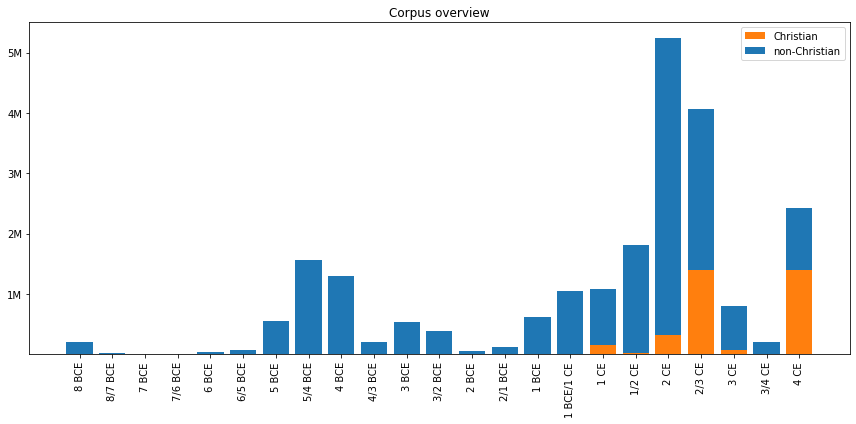

In [66]:
fig, ax = plt.subplots(figsize=(12, 6), tight_layout=True)
#subselections_df = subselections_df.iloc[::-1]
ax.bar(subselections_df["date_string"], subselections_df["wordcount_christian"], color="tab:orange", label="Christian")
ax.bar(subselections_df["date_string"], subselections_df["wordcount_pagan"], bottom=subselections_df["wordcount_christian"], label="non-Christian", color="tab:blue")


ax.set_yticks(range(1000000,6000000, 1000000))
ax.set_yticklabels(str(n) + "M" for n in range(1,6))
ax.set_xticklabels(subselections_df["date_string"], rotation=90)
ax.legend()
plt.title("Corpus overview")

In [67]:
sddk.write_file("SDAM_data/AGT/AGT_corpus_overview.png", fig, conf)

Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/AGT/AGT_corpus_overview.png"


In [68]:
subcorpora_dict = {# main subcorpora
    "Archaic (8-6 BCE)" : AGT[(AGT["provenience"]=="pagan") & (AGT["date_avr"] <= -5.5)],
    "Classical (5-4 BCE)" : AGT[(AGT["provenience"]=="pagan") & (AGT["date_avr"].between(-5, -3))],
    "Non-Christian (1-4 CE)" : AGT[(AGT["date_avr"].between(0, 4)) & (AGT["provenience"]=="pagan")],
    "Christian (1-4 CE)" : AGT[(AGT["date_avr"] < 4) & (AGT["provenience"]=="christian")]}
   
subcorpora_dict_other = {
    # other relevant subcorpora (some overlaps)
    "Pagan (8th c. BCE - 4th c. CE)" : AGT[(AGT["provenience"]=="pagan") & (AGT["date_avr"] < 4)],
    "Pagan (1st - 4th c. CE)" : AGT[(AGT["date_avr"].between(0, 4)) & (AGT["provenience"]=="pagan")],
    "Septuagint" : AGT[AGT["author_id"]=="tlg0527"],
    "Philo of Alexandria" : AGT[AGT["author_id"]=="tlg0018"],
    "Titus Flavius Josephus" : AGT[AGT["author_id"]=="tlg0526"],
    "Paul of Tarsus" : AGT[AGT["author_id"]=="tlg0031paul"],
    "New Testament" : AGT[AGT["author_id"].str.startswith("tlg0031")],
    "Christian (1st - 4th c. CE)" : AGT[(AGT["date_avr"] < 4) & (AGT["provenience"]=="christian")]}

In [69]:
subselections = []
for key in subcorpora_dict.keys():
    subselection = subcorpora_dict[key]
    subselection_dict = {}
    wordcount = subselection["wordcount"].sum()
    doccount = len(subselection)
    sentences = subselection["lemmatized_sentences"].apply(lambda x: len(x)).sum()
    subselection_dict.update({"label" : key, "wordcount" : wordcount, "doccount" : doccount, "sentences" : sentences})
    subselections.append(subselection_dict)
subselections_df = pd.DataFrame(subselections)
subselections_df

,label,wordcount,doccount,sentences
0,Archaic (8-6 BCE),264986,11,20391
1,Classical (5-4 BCE),3439210,338,227967
2,Non-Christian (1-4 CE),9172125,411,522210
3,Christian (1-4 CE),3366042,131,164501
